# PART 1
### Convolution: Correlation with a flipped kernal

In [1]:
import matplotlib.pyplot as plt
import numpy as np
def normalize(img):
    img = img.astype(np.float32)
    img = img - img.min()
    img = img / (img.max() + 1e-8)
    return img

def save_img(img, path):
    if img.ndim == 2:  # grayscale
        plt.imsave(path, normalize(img), cmap="gray")
    else:              # RGB
        plt.imsave(path, normalize(img))

def save_fig(path):
    plt.savefig(path, dpi=150, bbox_inches="tight")
    plt.close()

In [2]:
import numpy as np

def conv2d_four_loops(image, kernal):
    height, width = image.shape
    kHeight, kWidth = kernal.shape

    #flip the kernal (horizontally and vertically)
    flippedKernal = np.flip(np.flip(kernal, axis = 0), axis = 1)

    #pad so output image is same dimension as input
    padded = np.pad(image, ((kHeight//2, kHeight // 2), (kWidth // 2, kWidth // 2)), mode='constant', constant_values=0)
    #padding(image, kHeight // 2 , kWidth // 2)
    output = np.zeros((height, width))

    # 4 loop convolution
    for i in range(height):
        for j in range(width):
            weighted_sum = 0.0
            for k in range(kHeight):
                for l in range(kWidth):
                    weighted_sum += padded[i + k, j + l] * flippedKernal[k, l]
            output[i, j] = weighted_sum
    return output


def conv2d_two_loops(image, kernal):
    height, width = image.shape
    kHeight, kWidth = kernal.shape

    #flip the kernal (horizontally and vertically)
    flippedKernal = np.flip(kernal, axis = 0)
    flippedKernal = np.flip(flippedKernal, axis = 1)

    #pad so output image is same dimension as input
    padded = np.pad(image, ((kHeight//2, kHeight // 2), (kWidth // 2, kWidth // 2)), mode='constant')
    #padding(image, kHeight // 2 , kWidth // 2)
    output = np.zeros((height, width))

#     2 loop convolution
    for i in range(height):
        for j in range(width):
            update_kHeight = i+kHeight
            update_kWidth = j+kWidth
            patch = padded[i: update_kHeight, j:update_kWidth]
            output[i,j] = np.sum(patch * flippedKernal)
            
    return output


(3088, 2316)


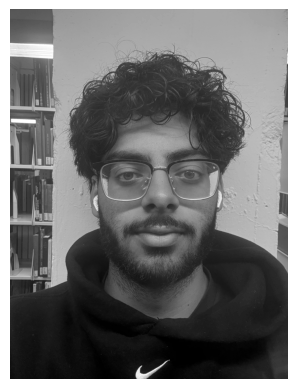

In [3]:
import matplotlib.pyplot as plt
img = plt.imread("/Users/jaitegchahal/cs180/jaitegchahal123.github.io/proj2/media/trial1.jpg")
gray = img.mean(axis = 2)
#check for exceeding float
if gray.max() > 1.5:
    gray = gray / 255.0
gray = np.rot90(gray.astype(np.float32), k=-1)
save_img(gray, "website/original_image.jpg")
print(gray.shape)
plt.imshow(gray, cmap="gray")
plt.axis("off")
plt.show()

In [13]:
box9 = np.ones((9,9), dtype=np.float32) / 81.0
Dx = np.array([[1, 0, -1]], dtype=np.float32)
Dy = np.array([[1], [0], [-1]], dtype=np.float32)

In [5]:
downsampled = gray[::4, ::4]
box9_two = conv2d_two_loops(downsampled, box9)
gx = conv2d_two_loops(downsampled, Dx)
gy = conv2d_two_loops(downsampled, Dy)

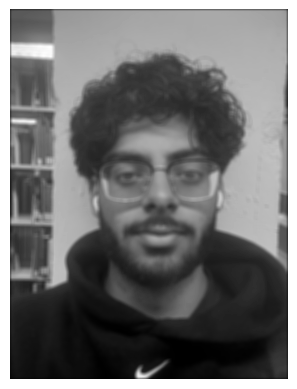

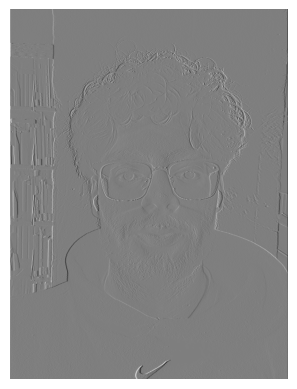

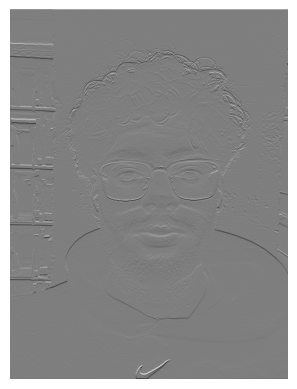

In [14]:
plt.imshow(box9_two, cmap="gray")
plt.axis("off")
plt.show()
save_img(box9_two, "website/box9.jpg")
plt.imshow(gx, cmap="gray")
plt.axis("off")
plt.show()
save_img(gx, "website/dx-operator.jpg")
plt.imshow(gy, cmap="gray")
plt.axis("off")
plt.show()
save_img(gy, "website/dy-operator.jpg")

# 1.2

In [15]:
from scipy.signal import convolve2d
img = plt.imread("/Users/jaitegchahal/cs180/jaitegchahal123.github.io/proj2/media/cameraman180.png")
gray = img.mean(axis = 2)
#Float checks
if gray.max() > 1.5:
    gray = gray / 255.0
gray = gray.astype(np.float32)
save_img(gray, "website/1.2_original.jpg")

#Convolve using convolve2d
Ix = convolve2d(gray, Dx, mode="same", boundary="fill", fillvalue=0)
Iy = convolve2d(gray, Dy, mode="same", boundary="fill", fillvalue=0)

#Gradient magnitude
    #U just = sqrt(Ix**2 + Iy**2) = c = sqrt(A^2 + B^2) => Hypotenuse
grad_mag = np.hypot(Ix, Iy)

# plt.imshow(grad_mag, cmap="gray")
# plt.axis("off") 
# plt.show()


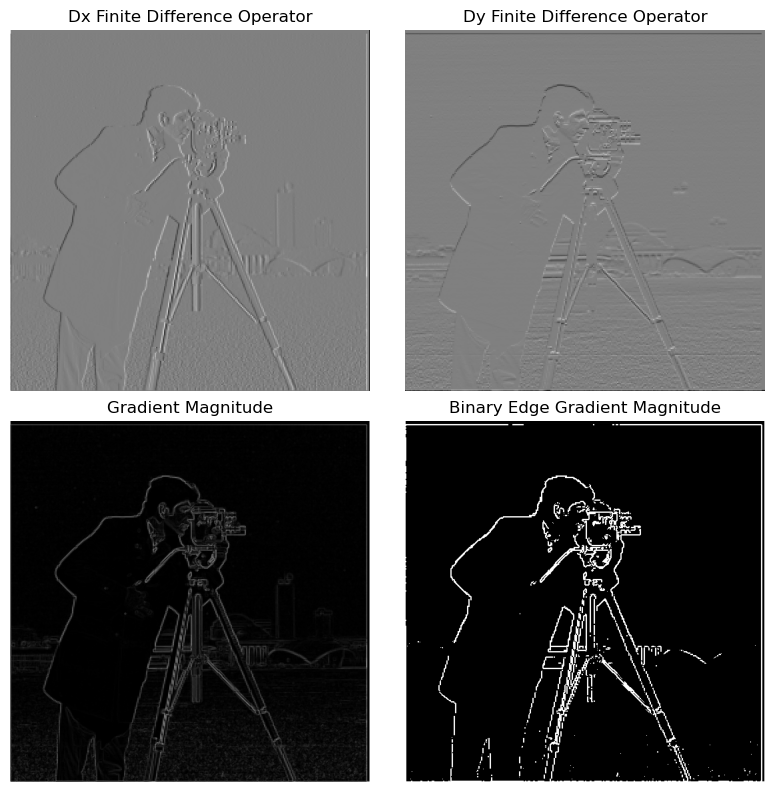

In [16]:
#edge image, lets binarize the gradient magnitude image by picking the appropriate threshold 
threshold = 0.22
edge_binary = (grad_mag >= threshold).astype(np.uint8)

plt.figure(figsize=(12, 8))

#plt.subplot(2,3,1); plt.imshow(gray, cmap="gray"); plt.title("Cameraman"); plt.axis("off")
plt.subplot(2,3,2); plt.imshow(Ix, cmap="gray"); plt.title("Dx Finite Difference Operator"); plt.axis("off")
plt.subplot(2,3,3); plt.imshow(Iy, cmap="gray"); plt.title("Dy Finite Difference Operator"); plt.axis("off")

# Normalize grad_mag for visualization only
gm_vis = grad_mag / (grad_mag.max() + 1e-8)
plt.subplot(2,3,5); plt.imshow(gm_vis, cmap="gray"); plt.title("Gradient Magnitude"); plt.axis("off")

plt.subplot(2,3,6); plt.imshow(edge_binary, cmap="gray"); plt.title("Binary Edge Gradient Magnitude"); plt.axis("off")

plt.tight_layout()
plt.savefig("website/1.2_full.jpg", dpi=150, bbox_inches="tight")
plt.show()


# 1.3

In [17]:
#Build the 2D Gaussian Kernal
def gaussian_2d(ksize, sigma):
# ksize = 11
# sigma = 1.6
    ax = np.arange(ksize) - (ksize // 2)
    g1 = np.exp(-(ax**2) / (2*sigma*sigma))
    g1 = g1 / g1.sum()
    G = np.outer(g1, g1).astype(np.float32)
    return G

def load_rgb(path):
    img = plt.imread(path).astype(np.float32)
    if img.max() > 1.5:   # uint8 → float
        img = img / 255.0
    if img.shape[-1] == 4:  # drop alpha if present
        img = img[..., :3]
    return img


G = gaussian_2d(11, 1.6)

# Blur -> Difference
cam_blur = convolve2d(gray, G, mode="same", boundary="symm")
Ix_blur  = convolve2d(cam_blur, Dx, mode="same", boundary="symm")
Iy_blur  = convolve2d(cam_blur, Dy, mode="same", boundary="symm")
gradA    = np.hypot(Ix_blur, Iy_blur)

thr = 0.13
edgesA = (gradA >= thr).astype(np.uint8)

Gx = convolve2d(G, Dx, mode="same")  # derivative-of-Gaussian in x
Gy = convolve2d(G, Dy, mode="same")  # derivative-of-Gaussian in y

Ix_dog = convolve2d(gray, Gx, mode="same", boundary="symm")
Iy_dog = convolve2d(gray, Gy, mode="same", boundary="symm")
gradB  = np.hypot(Ix_dog, Iy_dog)
edgesB = (gradB >= thr).astype(np.uint8)

# ===== Verify (they should match up to tiny numeric error) =====
print("max |Ix_blur - Ix_dog| =", float(np.max(np.abs(Ix_blur - Ix_dog))))
print("max |Iy_blur - Iy_dog| =", float(np.max(np.abs(Iy_blur - Iy_dog))))
print("max |gradA - gradB|   =", float(np.max(np.abs(gradA   - gradB))))


max |Ix_blur - Ix_dog| = 0.001281198114156723
max |Iy_blur - Iy_dog| = 0.0012551452964544296
max |gradA - gradB|   = 0.0015067309141159058


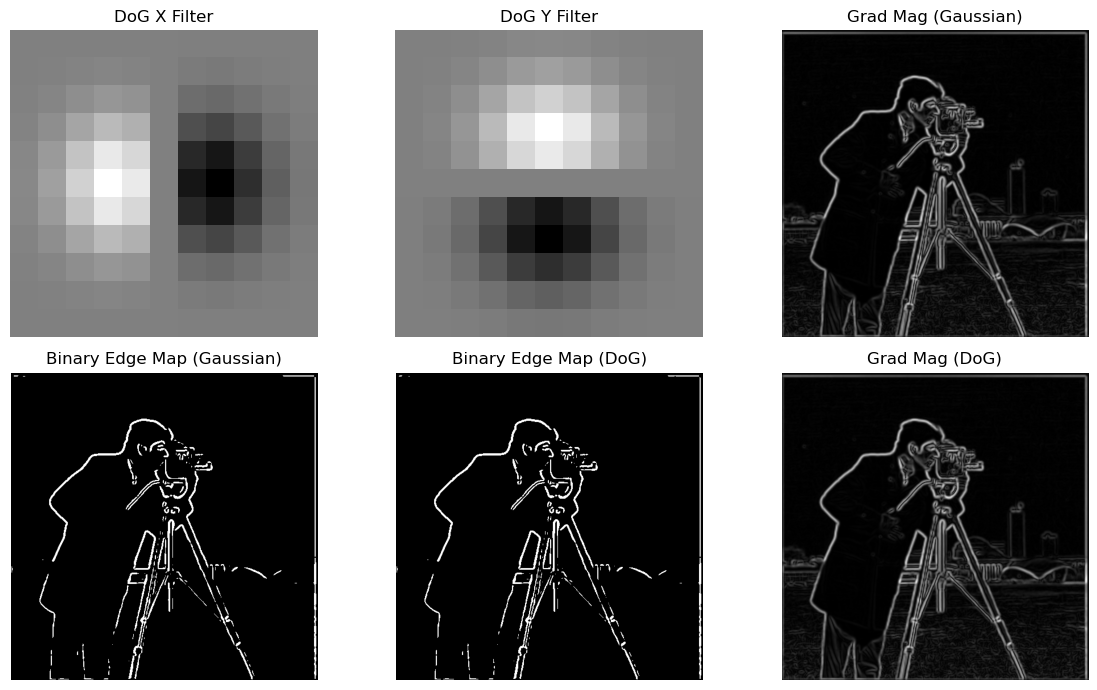

In [18]:
def vis(x):
    m, M = x.min(), x.max()
    return (x - m) / (M - m + 1e-8)

plt.figure(figsize=(12,7))
plt.subplot(2,3,1); plt.imshow(Gx, cmap="gray"); plt.title("DoG X Filter"); plt.axis("off")
plt.subplot(2,3,2); plt.imshow(Gy, cmap="gray"); plt.title("DoG Y Filter"); plt.axis("off")
plt.subplot(2,3,3); plt.imshow(vis(gradA), cmap="gray"); plt.title("Grad Mag (Gaussian)"); plt.axis("off")
plt.subplot(2,3,4); plt.imshow(edgesA, cmap="gray"); plt.title("Binary Edge Map (Gaussian)"); plt.axis("off")
plt.subplot(2,3,5); plt.imshow(edgesB, cmap="gray"); plt.title("Binary Edge Map (DoG)"); plt.axis("off")
plt.subplot(2,3,6); plt.imshow(vis(gradB), cmap="gray"); plt.title("Grad Mag (DoG)"); plt.axis("off")
plt.tight_layout();
plt.savefig("website/1.3full.jpg", dpi=150, bbox_inches="tight")
plt.show()

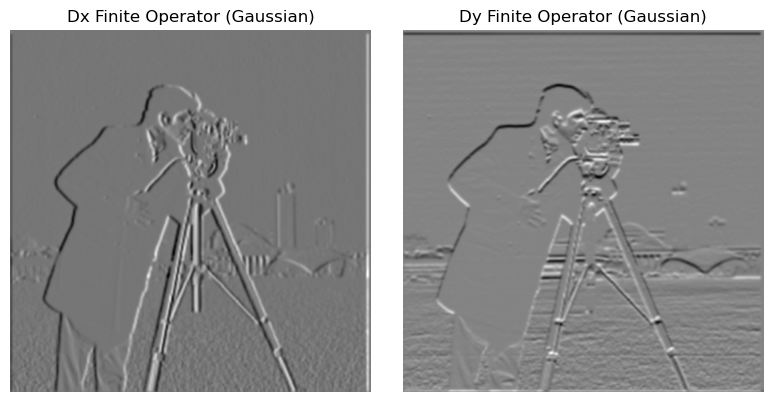

In [19]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(Ix_blur, cmap="gray")
plt.title("Dx Finite Operator (Gaussian)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(Iy_blur, cmap="gray")
plt.title("Dy Finite Operator (Gaussian)")
plt.axis("off")

plt.tight_layout()
plt.savefig("website/1.3_dx_and_dy.jpg", dpi=150, bbox_inches="tight")
plt.show()


# 2.1

In [20]:
def sharpen(image_paths, G, alpha=7):
    kH, kW = G.shape
    delta = np.zeros_like(G); delta[kH//2, kW//2] = 1.0
    K = (1 + alpha) * delta - alpha * G
    i = 0
    for path in image_paths:
        # --- Load image ---
        img = plt.imread(path).astype(np.float32)
        if img.max() > 1.5:
            img = img / 255.0
        if img.shape[-1] == 4:  # drop alpha if present
            img = img[..., :3]

        blurred = blur_color(img, G)
        high_freq = vis(img - blurred)

        # --- Single-kernel per channel ---
        sharp_one = np.empty_like(img)
        for c in range(3):
            sharp_one[..., c] = convolve2d(img[..., c], K, mode="same", boundary="symm")
        sharp_one = np.clip(sharp_one, 0, 1)

        # --- Show ---
        plt.figure(figsize=(15,4))
        plt.subplot(1,3,1)
        plt.imshow(img)
        plt.title(f"Input (α={alpha})")
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.imshow(high_freq)
        plt.title(f"High Frequency (α={alpha})")
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.imshow(sharp_one)
        plt.title(f"Unsharp (Sharpened, α={alpha})")
        plt.axis("off")


        name = "taj" + str(alpha)
        plt.tight_layout()
        plt.savefig(name, dpi=200, bbox_inches="tight")
        i+=1
        plt.close()

        
def blur_color(img, G):
    out = np.empty_like(img)
    for c in range(3):
        out[..., c] = convolve2d(img[..., c], G, mode="same", boundary="symm")
    return out


In [18]:
#apply the same gaussian 2d filter
G = gaussian_2d(11, 2.0)
sharp1 = load_rgb("/Users/jaitegchahal/cs180/jaitegchahal123.github.io/proj2/media/sharp1.jpg")
sharp1_blur = blur_color(sharp1, G)
sharp2 = load_rgb("/Users/jaitegchahal/cs180/jaitegchahal123.github.io/proj2/media/sharp2.jpg")
sharp2_blur = blur_color(sharp2, G)
sharp3 = load_rgb("/Users/jaitegchahal/cs180/jaitegchahal123.github.io/proj2/media/sharp3.jpg")
sharp3_blur = blur_color(sharp3, G)
taj_maj = load_rgb('/Users/jaitegchahal/cs180/jaitegchahal123.github.io/proj2/media/taj_mahal180.jpg')
ta_blur = blur_color(taj_maj, G)

save_img(sharp1_blur, "media/sharp1_blur.jpg")
save_img(sharp2_blur, "media/sharp2_blur.jpg")
save_img(sharp3_blur, "media/sharp3_blur.jpg")

# plt.figure(figsize=(10,4))
# plt.subplot(1,2,1); plt.imshow(sharp1);       plt.title("Original sharp1"); plt.axis("off")
# plt.subplot(1,2,2); plt.imshow(sharp1_blur);  plt.title("Blurred sharp1");  plt.axis("off")
# plt.tight_layout(); plt.show()

In [27]:
paths = ['/Users/jaitegchahal/cs180/jaitegchahal123.github.io/proj2/media/taj_mahal180.jpg']
#,
        #  '/Users/jaitegchahal/cs180/jaitegchahal123.github.io/proj2/media/sharp1_blur.jpg',
        #  '/Users/jaitegchahal/cs180/jaitegchahal123.github.io/proj2/media/sharp2_blur.jpg',
        #  '/Users/jaitegchahal/cs180/jaitegchahal123.github.io/proj2/media/sharp3_blur.jpg']
sharpen(paths, G)

In [21]:
import math
import numpy as np
import matplotlib.pyplot as plt
import skimage.transform as sktr



def get_points(im1, im2):
    print('Please select 2 points in each image for alignment.')
    plt.imshow(im1)
    p1, p2 = plt.ginput(2)
    plt.close()
    plt.imshow(im2)
    p3, p4 = plt.ginput(2)
    plt.close()
    return (p1, p2, p3, p4)

def recenter(im, r, c):
    R, C, _ = im.shape
    rpad = (int) (np.abs(2*r+1 - R))
    cpad = (int) (np.abs(2*c+1 - C))
    return np.pad(
        im, [(0 if r > (R-1)/2 else rpad, 0 if r < (R-1)/2 else rpad),
             (0 if c > (C-1)/2 else cpad, 0 if c < (C-1)/2 else cpad),
             (0, 0)], 'constant')

def find_centers(p1, p2):
    cx = np.round(np.mean([p1[0], p2[0]]))
    cy = np.round(np.mean([p1[1], p2[1]]))
    return cx, cy

def align_image_centers(im1, im2, pts):
    p1, p2, p3, p4 = pts
    h1, w1, b1 = im1.shape
    h2, w2, b2 = im2.shape
    
    cx1, cy1 = find_centers(p1, p2)
    cx2, cy2 = find_centers(p3, p4)

    im1 = recenter(im1, cy1, cx1)
    im2 = recenter(im2, cy2, cx2)
    return im1, im2

def rescale_images(im1, im2, pts):
    p1, p2, p3, p4 = pts
    len1 = np.sqrt((p2[1] - p1[1])**2 + (p2[0] - p1[0])**2)
    len2 = np.sqrt((p4[1] - p3[1])**2 + (p4[0] - p3[0])**2)
    dscale = len2/len1
    if dscale < 1:
        #im1 = sktr.rescale(im1, dscale)
        im1 = sktr.rescale(im1, dscale, channel_axis=2,
                   anti_aliasing=True, preserve_range=True)
    else:
        #im2 = sktr.rescale(im2, 1./dscale)
        im2 = sktr.rescale(im2, 1./dscale, channel_axis=2,
                   anti_aliasing=True, preserve_range=True)
    return im1, im2

def rotate_im1(im1, im2, pts):
    p1, p2, p3, p4 = pts
    theta1 = math.atan2(-(p2[1] - p1[1]), (p2[0] - p1[0]))
    theta2 = math.atan2(-(p4[1] - p3[1]), (p4[0] - p3[0]))
    dtheta = theta2 - theta1
    #im1 = sktr.rotate(im1, dtheta*180/np.pi)
    im1 = sktr.rotate(im1, dtheta*180/np.pi,
                  resize=False, mode='reflect',
                  preserve_range=True)

    return im1, dtheta

def match_img_size(im1, im2):
    H = min(im1.shape[0], im2.shape[0])
    W = min(im1.shape[1], im2.shape[1])

    def crop(x):
        h, w = x.shape[:2]
        top  = (h - H) // 2
        left = (w - W) // 2
        return x[top:top+H, left:left+W, :]

    im1c = crop(im1)
    im2c = crop(im2)
    assert im1c.shape == im2c.shape
    return im1c, im2c

def align_images(im1, im2):
    pts = get_points(im1, im2)
    im1, im2 = align_image_centers(im1, im2, pts)
    im1, im2 = rescale_images(im1, im2, pts)
    im1, angle = rotate_im1(im1, im2, pts)
    im1, im2 = match_img_size(im1, im2)
    return im1, im2

In [29]:
%matplotlib qt

In [30]:
# --- load (cat = high-pass, human = low-pass) ---
# cat   = load_rgb("/Users/jaitegchahal/cs180/jaitegchahal123.github.io/proj2/media/nutmeg.jpg")
# human = load_rgb("/Users/jaitegchahal/cs180/jaitegchahal123.github.io/proj2/media/DerekPicture.jpg")


cat   = load_rgb('/Users/jaitegchahal/cs180/jaitegchahal123.github.io/proj2/website/pp1.jpg')
human   = load_rgb('/Users/jaitegchahal/cs180/jaitegchahal123.github.io/proj2/website/pp2.jpg')

# cat = load_rgb("/Users/jaitegchahal/cs180/jaitegchahal123.github.io/proj2/media/jefferson.jpg")
# human = load_rgb('/Users/jaitegchahal/cs180/jaitegchahal123.github.io/proj2/media/madison.jpg')



# Transform CAT to match HUMAN (starter code transforms im1 -> im2)
cat_aligned, human_ref = align_images(cat, human)  # <- no extra cropping

# --- build hybrid in COLOR ---
G_low  = gaussian_2d(ksize=25, sigma=8.0)   # far (human)
G_high = gaussian_2d(ksize=25, sigma=3.5)   # near (cat)


L  = blur_color(human_ref, G_low)                    # low-pass human (color)
Hp = cat_aligned - blur_color(cat_aligned, G_high)   # high-pass cat (color, zero-mean)
Hp = Hp - Hp.mean(axis=(0,1), keepdims=True)

w_low, w_high = 1.2, 0.9
hybrid = np.clip(w_low*L + w_high*Hp, 0.0, 1.0)

low_derek = blur_color(human_ref, G_low)
save_img(low_derek, "website/low_derek.jpg")

# High-pass (Nutmeg) → shift by +0.5 just for visibility
high_nutmeg = np.clip(0.5 + Hp, 0, 1)
save_img(high_nutmeg, "website/high_nutmeg.jpg")

# --- visualize (color) ---
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(np.clip(L,0,1));      plt.title("Low-pass HUMAN (color)");      plt.axis("off")
plt.subplot(1,3,2); plt.imshow(np.clip(0.5+Hp,0,1)); plt.title("High-pass CAT (color, viz)");  plt.axis("off")
plt.subplot(1,3,3); plt.imshow(hybrid);               plt.title("Hybrid (color)");               plt.axis("off")
plt.tight_layout(); plt.show()

Please select 2 points in each image for alignment.


ValueError: not enough values to unpack (expected 2, got 0)

In [31]:
def to_gray(img):
    # luminance (works for RGB or gray already)
    if img.ndim == 3 and img.shape[-1] == 3:
        return (0.2126*img[...,0] + 0.7152*img[...,1] + 0.0722*img[...,2]).astype(np.float32)
    return img.astype(np.float32)

def fft_log_mag(gray):
    F = np.fft.fft2(gray)
    Fshift = np.fft.fftshift(F)
    return np.log(np.abs(Fshift) + 1e-8)

human_gray  = to_gray(human_ref)
cat_gray    = to_gray(cat_aligned)
L_gray      = to_gray(L)
Hp_gray     = to_gray(Hp)
hybrid_gray = to_gray(hybrid)

# ----- compute log-magnitude spectra -----
F_human  = fft_log_mag(human_gray)
F_cat    = fft_log_mag(cat_gray)
F_L      = fft_log_mag(L_gray)
F_Hp     = fft_log_mag(Hp_gray)
F_hybrid = fft_log_mag(hybrid_gray)

# ----- display -----
plt.figure(figsize=(14,8))

plt.subplot(2,5,6)
plt.imshow(F_human, cmap='gray')
plt.title("FFT Derek (unfiltered)")
plt.axis('off')

plt.subplot(2,5,7)
plt.imshow(F_cat, cmap='gray')
plt.title("FFT Nutmeg (unfiltered)")
plt.axis('off')

plt.subplot(2,5,8)
plt.imshow(F_L, cmap='gray')
plt.title("FFT Derek (Low-pass filtered)")
plt.axis('off')

plt.subplot(2,5,9)
plt.imshow(F_Hp, cmap='gray')
plt.title("FFT Nutmeg (High-pass filtered)")
plt.axis('off')

plt.subplot(2,5,10)
plt.imshow(F_hybrid, cmap='gray')
plt.title("FFT Hybrid (Derek + Nutmeg)")
plt.axis('off')

plt.tight_layout()
plt.show()



NameError: name 'human_ref' is not defined

In [32]:
%matplotlib inline

# 2.3

In [22]:
# --- better Gaussian kernel helper (choose σ, auto-odd size) ---
def gaussian_2d(ksize=None, sigma=3.0):
    if ksize is None:
        ksize = int(np.ceil(6*sigma)) | 1        # odd ~ 6σ
    ax = np.arange(ksize) - (ksize//2)
    g1 = np.exp(-(ax**2)/(2*sigma*sigma))
    g1 /= g1.sum()
    return np.outer(g1, g1).astype(np.float32)

def blur_color(img, K):
    out = np.empty_like(img, dtype=np.float32)
    for c in range(img.shape[2]):
        out[..., c] = convolve2d(img[..., c], K, mode="same", boundary="symm")
    return out

# --- stacks (same size levels; blur more by raising sigma) ---
def gaussian_stack(img, levels=6, sigma=3.0):
    K = gaussian_2d(sigma=sigma)
    G = [img.astype(np.float32)]
    cur = G[0]
    for _ in range(1, levels):
        cur = blur_color(cur, K)         # repeated blur -> progressively smoother
        G.append(cur)
    return G

def laplacian_stack(img, levels=6, sigma=3.0):
    G = gaussian_stack(img, levels, sigma)
    L = []
    for i in range(levels-1):
        L.append(G[i] - G[i+1])          # signed, zero-mean band
    L.append(G[-1])                      # residual (lowest freq)
    return L, G

# --- visualization helpers ---
def _to_disp_gaussian(im):
    return np.clip(im, 0, 1)

def _to_disp_laplacian(im):
    # normalize signed band per-level to [-1,1] then shift → [0,1]
    m = np.max(np.abs(im))
    if m < 1e-8: 
        return 0.5*np.ones_like(im)      # empty band
    return np.clip(0.5 + 0.5*im/m, 0, 1)

def show_stack_vertical(stack, title, is_laplacian=False):
    L = len(stack)
    plt.figure(figsize=(4, 3*L))
    for i, im in enumerate(stack):
        plt.subplot(L, 1, i+1)
        disp = _to_disp_laplacian(im) if is_laplacian else _to_disp_gaussian(im)
        if im.ndim == 2:
            plt.imshow(disp, cmap='gray')
        else:
            plt.imshow(disp)
        plt.axis('off'); plt.title(f"{title} — level {i}")
    plt.tight_layout()
    plt.savefig("image" + title, dpi=300, bbox_inches="tight")
    plt.show()


In [141]:
apple_path  = "/Users/jaitegchahal/cs180/jaitegchahal123.github.io/proj2/media/apple.jpeg"
orange_path = "/Users/jaitegchahal/cs180/jaitegchahal123.github.io/proj2/media/orange.jpeg"

# apple_path  = "/Users/jaitegchahal/cs180/jaitegchahal123.github.io/proj2/media/full_colosseum.jpeg"
# orange_path = "/Users/jaitegchahal/cs180/jaitegchahal123.github.io/proj2/media/broken_colosseum.jpg"

A = load_rgb(apple_path)
B = load_rgb(orange_path)

# stronger blur for clearer separation in the stack
sigma_vis = 3.5   # try 3.0–5.0; levels 6–7 is nice

LA, GA = laplacian_stack(A, levels=6, sigma=sigma_vis)
LB, GB = laplacian_stack(B, levels=6, sigma=sigma_vis)

show_stack_vertical(GA, "Gaussian Stack (Apple)", is_laplacian=False)
show_stack_vertical(LA, "Laplacian Stack (Apple)", is_laplacian=True)
show_stack_vertical(GB, "Gaussian Stack (Orange)", is_laplacian=False)
show_stack_vertical(LB, "Laplacian Stack (Orange)", is_laplacian=True)


# 2.4

In [30]:
def center_crop_to_smallest(a, b):
    H = min(a.shape[0], b.shape[0])
    W = min(a.shape[1], b.shape[1])
    def crop(x):
        top  = (x.shape[0]-H)//2
        left = (x.shape[1]-W)//2
        return x[top:top+H, left:left+W]
    return crop(a), crop(b)

import numpy as np

def soft_circular_mask(H, W, cx=None, cy=None, r=None, feather=0.25):
    """
    Radial cosine falloff: 1.0 at center, smoothly to 0.0 outside.
    feather: fraction of radius used for feathering (0.2–0.4 works well).
    """
    if cx is None: cx = W//2
    if cy is None: cy = H//2
    if r  is None: r  = min(H, W)//3
    y, x = np.ogrid[:H, :W]
    d = np.sqrt((x-cx)**2 + (y-cy)**2)
    r0 = r*(1.0 - feather)
    r1 = r
    m = np.zeros((H, W), np.float32)
    m[d <= r0] = 1.0
    ramp = (d > r0) & (d < r1)
    # cosine ramp from 1→0
    m[ramp] = 0.5 * (1 + np.cos(np.pi*(d[ramp]-r0)/(r1-r0)))
    return m  # HxW float32 in [0,1]


def make_step_mask(H, W, orientation="vertical", side="left"):
    """Binary 0/1 mask (3-ch) with a hard seam; we'll blur it in a Gaussian stack."""
    m = np.zeros((H, W, 1), dtype=np.float32)
    if orientation == "vertical":
        if side == "left":  m[:, :W//2, 0] = 1.0
        else:               m[:, W//2:, 0] = 1.0
    else:  # horizontal
        if side == "top":   m[:H//2, :, 0] = 1.0
        else:               m[H//2:, :, 0] = 1.0
    return np.repeat(m, 3, axis=2)

def make_circular_mask(H, W, cx=None, cy=None, r=None):
    """Irregular example: 1 inside a circle, 0 outside (3-ch)."""
    if cx is None: cx = W//2
    if cy is None: cy = H//2
    if r  is None: r  = min(H, W)//3
    y, x = np.ogrid[:H, :W]
    m = ((x - cx)**2 + (y - cy)**2 <= r*r).astype(np.float32)
    m = m[..., None]
    return np.repeat(m, 3, axis=2)

def gaussian_stack_levelwise(mask, levels, sigma0):
    # sigma grows linearly with level: sigma_i = sigma0*(i+1)
    Gs = []
    cur = mask.astype(np.float32)
    for i in range(levels):
        sig = sigma0 * (i + 1)
        K = gaussian_2d(ksize=int(6*sig+1)|1, sigma=sig)
        cur = blur_color(mask, K)   # blur the ORIGINAL mask each time
        Gs.append(cur)
    return Gs


def stack_blend(A, B, mask_0_1, levels=6, sigma_img=3.0, sigma_mask=5.0):
    """
    Multiresolution blending with STACKS (no downsampling).
    - Build Laplacian(A), Laplacian(B)
    - Build Gaussian stack of mask
    - Blend per level: Lblend[i] = M[i]*LA[i] + (1-M[i])*LB[i]
    - Reconstruct by summing blended Laplacian levels (stack telescopes)
    """
    # ensure same size
    A, B = center_crop_to_smallest(A, B)
    H, W = A.shape[:2]
    mask = mask_0_1.astype(np.float32)
    if mask.shape[:2] != (H, W):  # center-crop mask if needed
        mask, _ = center_crop_to_smallest(mask, A)

    # image stacks
    LA, _ = laplacian_stack(A, levels=levels, sigma=sigma_img)
    LB, _ = laplacian_stack(B, levels=levels, sigma=sigma_img)

    # Gaussian mask stack (this is what smooths the seam at each frequency)
    GM = gaussian_stack_levelwise(mask, levels=levels, sigma0=6.0)  # try 6–10



    # blend per level
    Lblend = [GM[i]*LA[i] + (1.0 - GM[i])*LB[i] for i in range(levels)]

    # reconstruct (stack = simple sum of Laplacian bands)
    out = np.zeros_like(A, dtype=np.float32)
    for band in Lblend:
        out += band
    return np.clip(out, 0, 1), (LA, LB, GM, Lblend)

def show_oraple_process(A, B, mask, levels_to_show=(0,2,4), sigma_img=3.0, sigma_mask=5.0):
    result, (LA, LB, GM, Lblend) = stack_blend(A, B, mask,
                                               levels=max(levels_to_show)+1,
                                               sigma_img=sigma_img, sigma_mask=sigma_mask)

    def disp_band(im):
        m = np.max(np.abs(im))
        if m < 1e-8: return 0.5*np.ones_like(im)
        return np.clip(0.5 + 0.5*im/m, 0, 1)

    rows = len(levels_to_show) + 1
    plt.figure(figsize=(10, 3.2*rows))

    # per-level contributions (apple band, orange band, sum)
    for r, k in enumerate(levels_to_show, start=1):
        a_band = GM[k]*LA[k]
        b_band = (1.0 - GM[k])*LB[k]
        s_band = a_band + b_band
        for c, (img, ttl) in enumerate([(a_band, f"Apple band k={k}"),
                                        (b_band, f"Orange band k={k}"),
                                        (s_band, f"Sum band k={k}")], start=1):
            plt.subplot(rows, 3, (r-1)*3 + c)
            plt.imshow(disp_band(img)); plt.axis('off'); plt.title(ttl)

    # bottom row: masked inputs & final mosaic
    plt.subplot(rows, 3, (rows-1)*3 + 1); plt.imshow(np.clip(mask,0,1)); plt.axis('off'); plt.title("Mask (0/1)")
    plt.subplot(rows, 3, (rows-1)*3 + 2); plt.imshow(A);                plt.axis('off'); plt.title("Apple")
    plt.subplot(rows, 3, (rows-1)*3 + 3); plt.imshow(result);           plt.axis('off'); plt.title("Blended (Oraple)")
    plt.tight_layout(); 
    plt.savefig("First-time-orange", dpi=300, bbox_inches="tight")
    plt.show()

    return result


def oraple_blend(A, B, mask, levels=6, sigma_img=3.0, sigma_mask=5.0, save_path=None):
    out, _ = stack_blend(A, B, mask, levels=levels,
                         sigma_img=sigma_img, sigma_mask=sigma_mask)

    plt.imshow(out)
    plt.axis("off")
    plt.title("Blended Result")
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    
    return out

def resize_max(img, max_side=2000):
    H,W = img.shape[:2]
    s = max(H, W)
    if s <= max_side: return img
    r = max_side / s
    import cv2
    return cv2.resize(img, (int(W*r), int(H*r)), interpolation=cv2.INTER_AREA)





In [174]:
apple_path  = '/Users/jaitegchahal/cs180/jaitegchahal123.github.io/proj2/website/test.jpg'
orange_path = '/Users/jaitegchahal/cs180/jaitegchahal123.github.io/proj2/website/test2.jpg'
A = load_rgb(apple_path)
B = load_rgb(orange_path)
A, B = center_crop_to_smallest(A, B)

# --- (a) Vertical Oraple ---
M_vert = make_step_mask(*A.shape[:2], orientation="vertical", side="left")
oraple = show_oraple_process(A, B, M_vert, levels_to_show=(0, 2, 4, 6, 8),
                             sigma_img=3.0, sigma_mask=6.0)

# --- (b) Irregular example (circle) ---
M_circ = make_circular_mask(*A.shape[:2], cx=A.shape[1]//2, cy=A.shape[0]//2, r=min(A.shape[:2])//3)
blend_circ = show_oraple_process(A, B, M_circ, levels_to_show=(0,2,4),
                                 sigma_img=3.0, sigma_mask=6.0)


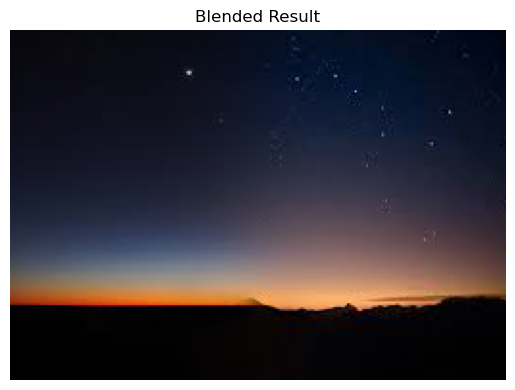

(183, 259, 3)
(183, 259, 3)


In [24]:
apple_path  = '/Users/jaitegchahal/cs180/jaitegchahal123.github.io/proj2/website/try1.jpeg'
orange_path = '/Users/jaitegchahal/cs180/jaitegchahal123.github.io/proj2/website/try2.jpeg'

A = load_rgb(apple_path)
B = load_rgb(orange_path)
A = resize_max(A, 2000); B = resize_max(B, 2000)
A, B = center_crop_to_smallest(A, B)

M_vert = make_step_mask(*A.shape[:2], orientation="vertical", side="left")

oraple = oraple_blend(A, B, M_vert, levels=5, sigma_img=3.0, sigma_mask=6.0,
                      save_path="website/oraple_bridge.png")
print(A.shape)
print(B.shape)


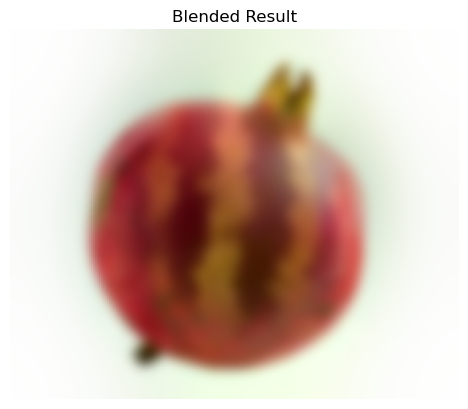

In [34]:
import cv2
import numpy as np

# --- load first ---
A = load_rgb(apple_path)
B = load_rgb(orange_path)
A, B = center_crop_to_smallest(A, B)   # make sizes identical

# --- build soft radial mask AFTER crop ---
M01 = soft_circular_mask(*A.shape[:2], r=min(A.shape[:2])//3, feather=0.35)  # HxW, float32

# expand to 3-ch so your code that multiplies per-channel works
M3 = np.repeat(M01[..., None], 3, axis=2)   # HxWx3

# --- FIX: gaussian stack should blur the *current* level, not the original each time ---
def gaussian_stack_levelwise(mask, levels, sigma0):
    Gs = []
    cur = mask.astype(np.float32)
    for i in range(levels):
        sig = sigma0 * (i + 1)
        k = int(6*sig) | 1
        cur = cv2.GaussianBlur(cur, (k, k), sig, borderType=cv2.BORDER_REFLECT)
        Gs.append(cur)
    return Gs

# call your blender with the 3-ch mask
oraple = oraple_blend(A, B, M3, levels=5, sigma_img=3.0, sigma_mask=6.0,
                      save_path="website/breh.png")
